In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ml_metrics import quadratic_weighted_kappa
import xgboost as xgb
import datetime as dt
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
import functools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support


# Define xgboost model class


In [2]:
#===============================================================================

from collections import namedtuple
ModelPrediction = namedtuple('ModelPrediction',
                             'ytrain ytest ystrain ystest yhtrain yhtest qwktrain qwktest')

def params2str(d, num_round):
    return ", ".join(["{0}:{1}".format(k, repr(d[k])) for k in sorted(d)] + 
                     ["{0}:{1}".format("num_round", num_round)])
    

class XGBoostModel:

    def __init__(self, nfolds=3):
        """
        Initialize the xgboost model by loading the imputed data from file.

        The train and test sets will be split according to the 'train?' column.
        
        Parameters
        ----------
        
        nfolds : int
            number of folds that will be used to setup cross validation
        
        
        Class data
        ----------

        self.features, self.labels :
        
            Features and labeles for all of the labeled data available.

        self.submisison_features :
        
            Features for the data that needs to be predicted in the submisison.

        self.classif_param :  dict
        
            A set of default parameters for using the 'multi:softmax' objective.

        self.linear_param : dict
        
            A set of default paramters for using the 'reg:linear' objective.
            
        self.cross_valid : list(tuple(array, array)) 
        
            A list of length equal to nfolds.  Each item represents a cross
            validation fold, and contains a tuple with index arrays for the
            training and testing data in the fold. 
            

        """

        data = pd.read_csv('csvs/data_imputed.csv')

        self.features = data[data['train?'] == True].drop(
            ['train?', 'Id', 'Response'], axis=1)
        self.labels = data[data['train?'] == True]['Response'] - 1

        self.submission_features = data[
            data['train?'] == False].drop(
            ['train?', 'Id', 'Response'],
            axis=1)

        self.classif_param = {}
        self.classif_param['objective'] = 'multi:softmax'
        self.classif_param['num_class'] = 8
        self.classif_param['eta'] = 0.1
        self.classif_param['max_depth'] = 6
        self.classif_param['min_child_weight'] = 1
        self.classif_param['subsample'] = 0.5
        self.classif_param['colsample_bytree'] = 0.67
        self.classif_param['silent'] = 1
        self.classif_param['nthread'] = 2

        #
        self.linear_param = {}
        self.linear_param['objective'] = 'reg:linear'
        self.linear_param['eta'] = 0.1
        self.linear_param['max_depth'] = 6
        self.linear_param['min_child_weight'] = 1
        self.linear_param['subsample'] = 0.5
        self.linear_param['colsample_bytree'] = 0.67
        self.linear_param['silent'] = 1
        self.linear_param['nthread'] = 1
        
        # Setup reusable folds for cross-validation 
        self.nfolds = nfolds
        self.cross_valid = list(KFold(len(self.features),
                                      n_folds=self.nfolds,
                                      shuffle=True,
                                      random_state=12))
        
        # List will store parameters and results every time the 
        # model is trained
        self.scores = []
        
        
    def make_split(self, train_size=0.7):
        """
        Splits data into train and test sets. 
        
        Parameters
        ----------
        train_size : float between 0 and 1
            Fraction of data in training set
            
        Returns
        -------
        xg_train : xgboost.DMatrix
            xgboost representation of the training features and labels
            
        xg_test : xgboolst.DMatrix
            xgboost representation of the testing features and labels
            
        ttsplit : tuple with len=4
            ttsplit[0] = Xtrain
            ttsplit[1] = Xtest
            ttsplit[2] = ytrain
            ttsplit[3] = ytest
        """
        
        if train_size < 1:
            ttsplit = train_test_split(
                self.features,
                self.labels,
                train_size=train_size,
                random_state=17)
        else:
            ttsplit = (self.features, None, self.labels, None)

        xg_train = xgb.DMatrix(ttsplit[0], ttsplit[2])
        xg_test = xgb.DMatrix(ttsplit[1], ttsplit[3])
        
        return xg_train, xg_test
    
    
    def make_cv_split(self, cvindex):
        """
        Splits data into training and test sets, according to the reusable
        cross validation folds that were prepared during initialization.
        
        Parameters
        ----------
        
        cvindex : int 
           
            Index of cross validation item that will be used to split the
            data
        """
        
        if cvindex >= self.nfolds:
            raise ValueError('make_cv_split error: ' + 
                             'Invalid index {}'.format(cvindex) +
                             'Only {} folds'.format(self.nfolds) +
                             'are setup for cross validation. ')
        
        idx_train = self.cross_valid[cvindex][0]
        idx_test = self.cross_valid[cvindex][1]
            
        ttsplit = (self.features.values[idx_train], self.features.values[idx_test],
                   self.labels.values[idx_train], self.labels.values[idx_test])
        
        xg_train = xgb.DMatrix(ttsplit[0], ttsplit[2])
        xg_test = xgb.DMatrix(ttsplit[1], ttsplit[3])
        
        return xg_train, xg_test
    
    
    def predict(self, model, xg_train, xg_test, objective='reg:linear'):
        """
        Parameters
        ----------
        
        model : xgboost.Booster
            xgboost model ready for making predictions
            
        xg_train : xgboost.DMatrix
            training data 
            
        xg_test : xgboost.DMatrix
            testing data
            
            
        Returns
        -------
        
        model_prediction : ModelPrediction (named tuple)
            [0] training xgb.DMatrix
            [1] testing xgb.DMatrix
            [2] training quadratic weighted kappa
            [3] testing quadratic weighted kappa
            
        """
        
        train_score = model.predict(
            xg_train, ntree_limit=model.best_iteration)
        test_score = model.predict(
            xg_test,  ntree_limit=model.best_iteration)
        
        if objective == 'reg:linear':
            def classify(score):
                score = np.asarray(score)
                return np.rint(np.clip(score, -0.49, 7.49))
            
            train_prediction = classify(train_score)
            test_prediction = classify(test_score)
        else:
            train_prediction = train_score
            test_prediction = test_score
            
        train_label = np.asarray(xg_train.get_label())
        test_label = np.asarray(xg_test.get_label()) 
        
        train_qwk = quadratic_weighted_kappa(train_label, train_prediction)
        test_qwk = quadratic_weighted_kappa(test_label, test_prediction)
        
        return ModelPrediction(train_label, test_label,
                               train_score, test_score,
                               train_prediction, test_prediction,
                               train_qwk, test_qwk)


    def learn_model(self, fold=0.7, objective='reg:linear', num_round=50,
                    make_plot=True, **kwargs):
        """
        Train an xgb ensemble of trees.
        
        
        Parameters
        ----------

        fold : Number in the range (0,1) or int in range(len(self.cross_valid))
        
            If number is a float in the range 0 < fold < 1, it will be
            interpreted as a train_size percentage in a train-test split.  
            
            If number is an integer in the range(len(self.cross_valid)) it 
            will be interpreted as an index in the list of reusable cross
            validation forms that were set up during class initialization.

        num_round : int,
        
            Number of boosting rounds.

        make_plot : bool,
        
            Make a plot evaluating the model results
            
            
        Returns
        -------
        
        model : The xgboost model
        
        pred : ModelPrediction tuple
        """
        
        
        if float(fold) > 0 and float(fold) < 1:
            xg_train, xg_test = self.make_split(train_size=fold)
            sample = '{:0.2f}'.format(fold)
        elif int(fold) in range(len(self.cross_valid)):
            xg_train, xg_test = self.make_cv_split(int(fold))
            sample = 'CV{:d}'.format(fold)
        else:
            raise ValueError("learn_model error: "
                             "invalid value for "
                            )        
        
        if objective == 'reg:linear':
            params = self.linear_param
        elif objective == 'multi:softmax':
            params = self.classif_param
        else:
            raise ValueError("learn_model error: "
                             "{} is not a valid objective".format(objective))
            
        for key, val in kwargs.items():
            if key in params.keys():
                params[key] = val            
            
        model = xgb.train(params, xg_train, num_round)
        pred = self.predict(model, xg_train, xg_test, objective=objective)
        
        self.save_score(sample, params, num_round, pred, make_plot=make_plot)
        
        return model, pred

            
    
    def cv_model(self, **kwargs):
        """
        Learns the model on each of the cross validation folds in 
        self.cross_valid
        """
        
        for i in range(self.nfolds):
            self.learn_model(fold=i, **kwargs)
            
    
    def get_scores(self):
        """
        Makes a dataframe with all of the recorded scores. 
        
        Returns
        -------
        
        df_score : pandas.DataFrame
        
            Each row represents a fit of the model with certain
            paramters and conditions. 
        """
        
        return pd.DataFrame(self.scores)
            
    
    def save_score(self, sample, params, num_round, pred, make_plot=True):
        """
        Saves the results of the model as a dictionary
        
        Parameters
        ----------
        
        sample : string
            
            A string that describes how the training and testing 
            sets were split. If string is a decimal number, then 
            split was a random train-test split.  If string is like
            CV#, then the #th precalculated cv split was used. 
            
        params : dict
            
            Parameters that were used to fit the model 
            
        num_rounds : int 
        
            number of boosting rounds used
            
        pred : ModelPrediction
        
            named tuple with the prediction results
        
        """
        
        score = params.copy()
        score['sample'] = sample
        score['num_round'] = num_round
        score['train_qwk'] = pred.qwktrain
        score['test_qwk']= pred.qwktest
        
        precision, recall, fscore, _ = precision_recall_fscore_support(
            pred.ytrain, pred.yhtrain, average='micro')
        
        score['train_precision'] = precision
        score['train_recall'] = recall
        score['train_fbetascore'] = fscore
        
        precision, recall, fscore, _ = precision_recall_fscore_support(
            pred.ytest, pred.yhtest, average='micro')
        
        score['test_precision'] = precision
        score['test_recall'] = recall
        score['test_fbetascore'] = fscore
        
        self.scores.append(score)
        if make_plot:
            self.make_plot_eval(params, num_round, pred)
            

    def make_plot_eval(self, params, num_round, pred):
        """
        Makes a plot that evaluates a prediction with respect to known labels. The
        plot consists of two panels: freq vs category on the left panel and confusion
        matrix on the right panel.
        
        Parameters
        ----------
        
        params : dict
        
            Dictionary with the model parameters.
        
        num_round : int
        
            Number of boosting rounds used during training.
            
        pred : ModelPrediction 
          
            A named tuple that contains the prediction results.
        """
        
        # Setup texts for the plot 
        text = "{} eta:{:0.2f}, max_depth:{:d}\n".format(
                self.classif_param['objective'],
                self.classif_param['eta'],
                self.classif_param['max_depth'],) + \
            "min_child_weight:{:0.2f}, num_round:{:02d}".format(   
                self.classif_param['min_child_weight'],
                num_round)   
        ktrain = '${}={:0.4f}$, '.format(
            '\kappa_{{q,\mathrm{{train}}}}',
            pred.qwktrain)
        ktest = '${}={:0.4f}$'.format(
            '\kappa_{{q,\mathrm{{train}}}}',
            pred.qwktest)
        kappa_text = ktrain + ktest
        
        # Define label and prediction 
        y, yhat = pred.ytest, pred.yhtest

        # Make the figure
        fig, ax = plt.subplots(1, 2, figsize=(9., 4.))

        y = pd.Series(y)
        yhat = pd.Series(yhat)

        yhist = y.value_counts()
        yhathist = yhat.value_counts()

        ax[0].scatter(
            yhist.index,
            yhist.values,
            s=40,
            c='blue',
            alpha=0.5,
            label='response')
        ax[0].scatter(
            yhathist.index-0.1,
            yhathist.values,
            s=40,
            c='green',
            alpha=0.5,
            label='prediction')

        ax[0].legend(loc='upper left', prop={'size': 10})
        ax[0].set_xlabel('classification')
        ax[0].set_ylabel('frequency')

        ax[0].text(0.99, 1.01, text, fontsize=9,
                   ha='right', va='bottom', transform=ax[0].transAxes)

        cm = confusion_matrix(y, yhat)
        print(cm)

        im = ax[1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax[1].set_xlabel('true label')
        ax[1].set_ylabel('predicted label')
        plt.colorbar(im)

        ax[1].text(0.99, 1.01, kappa_text, fontsize=12,
                   ha='right', va='bottom', transform=ax[1].transAxes)

        fname = 'plots/classification_' + text.replace(
            ':', '').replace(
            ', ', '_').replace(
            ' ', '') + '.png'
        fig.savefig(fname, dpi=150)


# Test XGBoostModel class with a few simple examples

[[ 369  249   28   62  151  392  204  434]
 [ 164  456   25   48  213  419  188  422]
 [  18   17  106  105   27   21    9   18]
 [   9    2   17  327    0   23   11   54]
 [  38  130    0    0  883  302   88  176]
 [  94  100    1    7  117 1786  413  780]
 [  45   14    0    0   12  468  923  997]
 [  11    9    0    4   13  195  189 5432]]


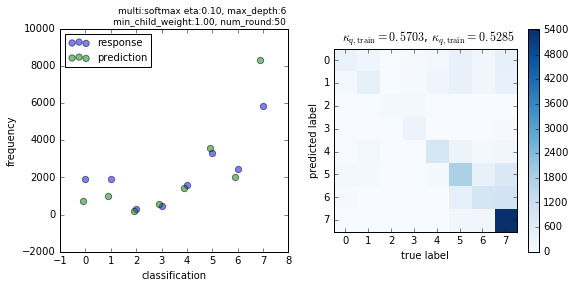

In [12]:
booster = XGBoostModel(nfolds=3)
booster.learn_model(fold=0.7, objective='multi:softmax', num_round=50, make_plot=True)

[[ 416  249   45   49  168  432  217  458]
 [ 172  531   41   46  248  478  211  489]
 [  10   11  136   89   31   26    4   14]
 [   7    4   16  343    0   33    7   52]
 [  56  150    1    0  940  389  106  188]
 [  97  101    2    2  113 2060  443  880]
 [  30   10    0    0   10  498 1030 1127]
 [  19   16    0    2   14  228  198 6051]]
[[ 412  262   38   70  149  413  218  533]
 [ 194  499   36   53  257  403  219  502]
 [  18   13  128  104   30   43    6   12]
 [   9    0   22  335    0   44    8   59]
 [  55  145    0    0 1034  308   91  202]
 [ 146  144    1    3  182 1998  451  895]
 [  38   11    0    1   19  464 1029 1078]
 [  14    7    0    3    9  187  199 5991]]
[[ 449  248   25   74  179  409  225  469]
 [ 205  516   27   46  270  436  196  477]
 [  29   16  116  112   31   18    4   12]
 [  11    2   18  354    0   30   12   62]
 [  45  137    1    0  960  336  100  188]
 [ 122  140    2    8  157 2006  448  832]
 [  50   25    0    1   16  465 1024 1101]
 [   9   

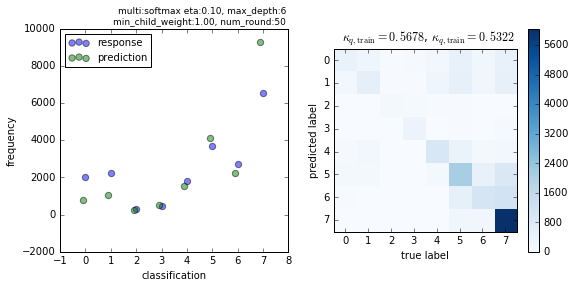

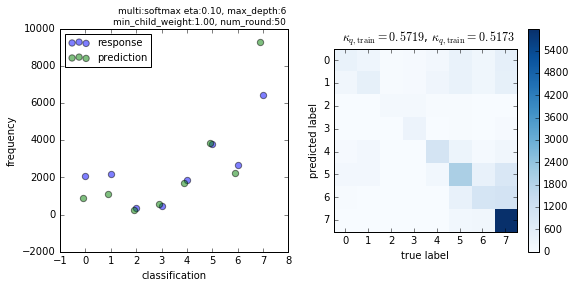

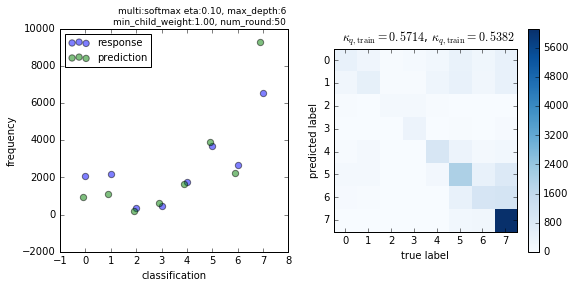

In [14]:
booster = XGBoostModel(nfolds=3)
booster.cv_model(objective='multi:softmax', num_round=50, make_plot=True)

In [15]:
booster.get_scores()

,colsample_bytree,eta,max_depth,min_child_weight,nthread,num_class,num_round,objective,sample,silent,subsample,test_fbetascore,test_precision,test_qwk,test_recall,train_fbetascore,train_precision,train_qwk,train_recall
0,0.67,0.1,6,1,2,8,50,multi:softmax,CV0,1,0.5,0.581338,0.581338,0.532241,0.581338,0.624170,0.624170,0.567807,0.624170
1,0.67,0.1,6,1,2,8,50,multi:softmax,CV1,1,0.5,0.577246,0.577246,0.517326,0.577246,0.623841,0.623841,0.571934,0.623841
2,0.67,0.1,6,1,2,8,50,multi:softmax,CV2,1,0.5,0.583944,0.583944,0.538194,0.583944,0.623244,0.623244,0.571400,0.623244


[[ 474  262   31   49  139  368  194  372]
 [ 241  509   23   41  213  395  165  348]
 [  32   25  113   84   25   21    7   14]
 [  21    7   22  310    0   18   13   52]
 [  59  151    0    0  876  283   88  160]
 [ 149  142    2    5  121 1758  459  662]
 [  68   47    0    1   15  391 1033  904]
 [  38   24    0    4   12  190  247 5338]]
[[ 187  228  296  344  347  285  176   26]
 [  77  254  342  389  398  285  171   19]
 [  15   57  139   62   22   15   10    1]
 [   5   10  135  203   22   20   40    8]
 [   8   35  201  434  604  211  116    8]
 [   5   37  149  397  961 1180  504   65]
 [   0    9   32   98  414  928  849  129]
 [   0    1    8   42  226  976 3032 1568]]


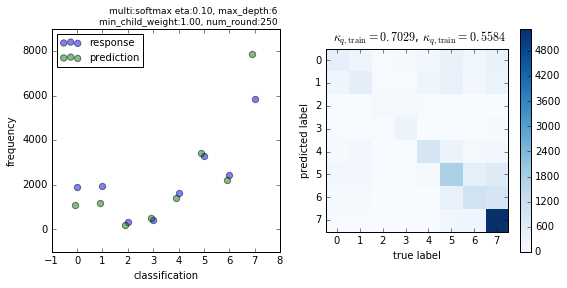

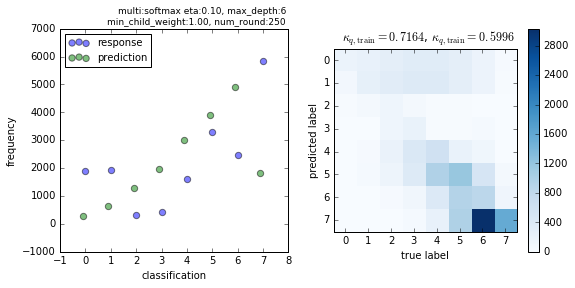

In [16]:
booster.learn_model(0.7, objective='multi:softmax', num_round=250, make_plot=True)
booster.learn_model(0.7, objective='reg:linear', num_round=250, make_plot=True)

In [17]:
booster.get_scores()

,colsample_bytree,eta,max_depth,min_child_weight,nthread,num_class,num_round,objective,sample,silent,subsample,test_fbetascore,test_precision,test_qwk,test_recall,train_fbetascore,train_precision,train_qwk,train_recall
0,0.67,0.1,6,1,2,8,50,multi:softmax,CV0,1,0.5,0.581338,0.581338,0.532241,0.581338,0.624170,0.624170,0.567807,0.624170
1,0.67,0.1,6,1,2,8,50,multi:softmax,CV1,1,0.5,0.577246,0.577246,0.517326,0.577246,0.623841,0.623841,0.571934,0.623841
2,0.67,0.1,6,1,2,8,50,multi:softmax,CV2,1,0.5,0.583944,0.583944,0.538194,0.583944,0.623244,0.623244,0.571400,0.623244
3,0.67,0.1,6,1,2,8,250,multi:softmax,0.70,1,0.5,0.584395,0.584395,0.558439,0.584395,0.733845,0.733845,0.702867,0.733845
4,0.67,0.1,6,1,1,NaN,250,reg:linear,0.70,1,0.5,0.279764,0.279764,0.599637,0.279764,0.315811,0.315811,0.716410,0.315811


# Tune some of the parameters by doing a grid search 

## Start with: `eta`,   `max_depth`,   `min_child_weight`

If model has high variance (large diff in test-train at full dataset):

* decrease eta
* decrease max depth
* increase min child weight

If model has high bias (small diff in test-train at full dataset):

* increase eta
* increase max depth
* decrease min child weight

In [ ]:
import itertools

booster_tune = XGBoostModel(nfolds=3)

for eta, max_depth, min_child_weight in itertools.product([0.025,0.05, 0.75], [6, 8, 10], [50, 100, 150]):
    print("Fitting: ", eta, max_depth, min_child_weight)
    booster_tune.learn_model(0.7, objective='reg:linear', num_round=250, make_plot=False,
                       eta=eta,
                       max_depth=max_depth,
                       min_child_weight=min_child_weight)

In [34]:
df_tune01 = booster_tune.get_scores().sort_values(by='test_qwk')
df_tune01.to_csv('models/df_tune01.csv', index=False)
results = df_tune01[['eta', 'max_depth', 'min_child_weight', 'test_qwk', 'train_qwk']]
results.join(pd.Series(results['train_qwk'] / results['test_qwk'], name='ratio'))

,eta,max_depth,min_child_weight,test_qwk,train_qwk,ratio
24,0.750,10,50,0.407222,0.902254,2.215632
25,0.750,10,100,0.442098,0.857747,1.940174
21,0.750,8,50,0.454573,0.842460,1.853299
26,0.750,10,150,0.464376,0.830059,1.787473
22,0.750,8,100,0.476571,0.807000,1.693347
23,0.750,8,150,0.486071,0.786400,1.617870
18,0.750,6,50,0.504181,0.771395,1.529995
19,0.750,6,100,0.514751,0.748200,1.453518
20,0.750,6,150,0.527122,0.729651,1.384217
2,0.025,6,150,0.562941,0.587032,1.042796


# Run another grid search

This time using `eta`,  `colsample_by_tree`, and `subsample`.   For `max_depth` and `min_child_weight`, use reasonable parameters for what was found in the previous search. 

In [36]:
import itertools

booster_tune = XGBoostModel(nfolds=3)

for eta, colsample_bytree, subsample in itertools.product([0.04,0.06], [0.2, 0.5, 0.8], [0.2, 0.5, 0.8]):
    print("Fitting: ", eta, colsample_bytree, subsample)
    booster_tune.learn_model(0.7, objective='reg:linear', num_round=250, make_plot=False,
                             eta=eta,
                             max_depth=8,
                             min_child_weight=100,
                             colsample_bytree=colsample_bytree,
                             subsample=subsample)

Fitting:  0.04 0.2 0.2
Fitting:  0.04 0.2 0.5
Fitting:  0.04 0.2 0.8
Fitting:  0.04 0.5 0.2
Fitting:  0.04 0.5 0.5
Fitting:  0.04 0.5 0.8
Fitting:  0.04 0.8 0.2
Fitting:  0.04 0.8 0.5
Fitting:  0.04 0.8 0.8
Fitting:  0.06 0.2 0.2
Fitting:  0.06 0.2 0.5
Fitting:  0.06 0.2 0.8
Fitting:  0.06 0.5 0.2
Fitting:  0.06 0.5 0.5
Fitting:  0.06 0.5 0.8
Fitting:  0.06 0.8 0.2
Fitting:  0.06 0.8 0.5
Fitting:  0.06 0.8 0.8


In [40]:
df_tune02 = booster_tune.get_scores().sort_values(by='test_qwk')
df_tune02.to_csv('models/df_tune02.csv', index=False)
results = df_tune02[['eta', 'max_depth', 'min_child_weight', 'colsample_bytree', 'subsample', 'test_qwk', 'train_qwk']]
results.join(pd.Series(results['train_qwk'] / results['test_qwk'], name='ratio'))

,eta,max_depth,min_child_weight,colsample_bytree,subsample,test_qwk,train_qwk,ratio
0,0.04,8,100,0.2,0.2,0.563249,0.591068,1.049389
9,0.06,8,100,0.2,0.2,0.571525,0.612096,1.070986
1,0.04,8,100,0.2,0.5,0.578115,0.617035,1.067323
3,0.04,8,100,0.5,0.2,0.578207,0.612483,1.059280
6,0.04,8,100,0.8,0.2,0.580195,0.616527,1.062620
2,0.04,8,100,0.2,0.8,0.581762,0.627885,1.079283
12,0.06,8,100,0.5,0.2,0.582061,0.627368,1.077839
15,0.06,8,100,0.8,0.2,0.583464,0.634073,1.086740
10,0.06,8,100,0.2,0.5,0.588139,0.637964,1.084717
4,0.04,8,100,0.5,0.5,0.591119,0.635685,1.075394


# Another grid search

In [41]:
import itertools

booster_tune = XGBoostModel(nfolds=3)

for max_depth, min_child_weight in itertools.product([7, 8, 9, 10, 11], [50, 100, 150, 200, 400]):
    print("Fitting: ", max_depth, min_child_weight)
    booster_tune.learn_model(0.7, objective='reg:linear', num_round=250, make_plot=False,
                             eta=eta,
                             max_depth=max_depth,
                             min_child_weight=min_child_weight,
                             colsample_bytree=0.8,
                             subsample=0.8)

Fitting:  7 50
Fitting:  7 100
Fitting:  7 150
Fitting:  7 200
Fitting:  7 400
Fitting:  8 50
Fitting:  8 100
Fitting:  8 150
Fitting:  8 200
Fitting:  8 400
Fitting:  9 50
Fitting:  9 100
Fitting:  9 150
Fitting:  9 200
Fitting:  9 400
Fitting:  10 50
Fitting:  10 100
Fitting:  10 150
Fitting:  10 200
Fitting:  10 400
Fitting:  11 50
Fitting:  11 100
Fitting:  11 150
Fitting:  11 200
Fitting:  11 400


In [42]:
df_tune03 = booster_tune.get_scores().sort_values(by='test_qwk')
df_tune03.to_csv('models/df_tune03.csv', index=False)
results = df_tune03[['eta', 'max_depth', 'min_child_weight', 'colsample_bytree', 'subsample', 'test_qwk', 'train_qwk']]
results.join(pd.Series(results['train_qwk'] / results['test_qwk'], name='ratio'))

,eta,max_depth,min_child_weight,colsample_bytree,subsample,test_qwk,train_qwk,ratio
4,0.06,7,400,0.8,0.8,0.585051,0.622360,1.063769
9,0.06,8,400,0.8,0.8,0.587162,0.628945,1.071161
14,0.06,9,400,0.8,0.8,0.588477,0.635070,1.079175
19,0.06,10,400,0.8,0.8,0.589631,0.639433,1.084464
24,0.06,11,400,0.8,0.8,0.590168,0.644470,1.092012
3,0.06,7,200,0.8,0.8,0.596313,0.642705,1.077798
2,0.06,7,150,0.8,0.8,0.598010,0.649651,1.086356
1,0.06,7,100,0.8,0.8,0.598681,0.660423,1.103129
8,0.06,8,200,0.8,0.8,0.599601,0.651928,1.087269
13,0.06,9,200,0.8,0.8,0.600233,0.662035,1.102964


# Run the previous grid search, but use classification rather than regression

In [45]:
import itertools

booster_tune = XGBoostModel(nfolds=3)

for max_depth, min_child_weight in itertools.product([7, 8, 9], [20, 50, 100, 150, 200]):
    print("Fitting: ", max_depth, min_child_weight)
    booster_tune.learn_model(0.7, objective='multi:softmax', num_round=250, make_plot=False,
                             eta=eta,
                             max_depth=max_depth,
                             min_child_weight=min_child_weight,
                             colsample_bytree=0.8,
                             subsample=0.8)

Fitting:  7 20
Fitting:  7 50
Fitting:  7 100
Fitting:  7 150
Fitting:  7 200
Fitting:  8 20
Fitting:  8 50
Fitting:  8 100
Fitting:  8 150
Fitting:  8 200
Fitting:  9 20
Fitting:  9 50
Fitting:  9 100
Fitting:  9 150
Fitting:  9 200


In [46]:
df_tune04 = booster_tune.get_scores().sort_values(by='test_qwk')
df_tune04.to_csv('models/df_tune04.csv', index=False)
results = df_tune04[['eta', 'max_depth', 'min_child_weight', 'colsample_bytree', 'subsample', 'test_qwk', 'train_qwk']]
results.join(pd.Series(results['train_qwk'] / results['test_qwk'], name='ratio'))

,eta,max_depth,min_child_weight,colsample_bytree,subsample,test_qwk,train_qwk,ratio
9,0.06,8,200,0.8,0.8,0.526835,0.555561,1.054526
4,0.06,7,200,0.8,0.8,0.529290,0.553540,1.045816
14,0.06,9,200,0.8,0.8,0.529411,0.555734,1.049721
3,0.06,7,150,0.8,0.8,0.532004,0.565357,1.062693
8,0.06,8,150,0.8,0.8,0.535624,0.568931,1.062182
13,0.06,9,150,0.8,0.8,0.535631,0.570746,1.065559
2,0.06,7,100,0.8,0.8,0.543223,0.578594,1.065114
12,0.06,9,100,0.8,0.8,0.543239,0.589505,1.085167
7,0.06,8,100,0.8,0.8,0.543608,0.584940,1.076032
1,0.06,7,50,0.8,0.8,0.548436,0.604702,1.102595


# Combining results from classification and regression

I want to see if using a combination of a classification model and a regression model can yield better results.


Regression good set of parameters:

* eta = 0.06
* max_depth = 9
* min_child_weight = 150
* colsasmple_bytree = 0.8
* subsample = 0.8
* test_qwk = 0.602483, train_qwk = 0.672166, ratio = 1.115661

Classification good set of parameters:

* eta = 0.06
* max_depth = 8
* min_child_weight = 50
* colsasmple_bytree = 0.8
* subsample = 0.8
* test_qwk = 0.553350, train_qwk = 0.617854, ratio = 1.116571

In [3]:
booster = XGBoostModel(nfolds=3)

fold = 1 # the fold to use for train-test split

reg, regpred = booster.learn_model(fold, objective='reg:linear', num_round=250, make_plot=False,
                               eta=0.06,
                               max_depth=9,
                               min_child_weight=150,
                               colsample_bytree=0.8,
                               subsample=0.8)

cls, clspred = booster.learn_model(fold, objective='multi:softmax', num_round=250, make_plot=False,
                               eta=0.06,
                               max_depth=8,
                               min_child_weight=50,
                               colsample_bytree=0.8,
                               subsample=0.8)

booster.get_scores()[['objective', 'train_qwk', 'test_qwk']]

Let's take a look at the precision and recall of the regression and classification models:

In [7]:
print("REGRESSION:")
regmetrics = pd.DataFrame(np.vstack(precision_recall_fscore_support(regpred.ytest, regpred.yhtest)).T, 
             columns=['precision', 'recall', 'fscore', 'support'])
regmetrics

REGRESSION:


,precision,recall,fscore,support
0,0.648515,0.062530,0.114062,2095
1,0.402102,0.141470,0.209302,2163
2,0.105634,0.466102,0.172234,354
3,0.088353,0.415094,0.145695,477
4,0.200000,0.365123,0.258438,1835
5,0.318874,0.361780,0.338975,3820
6,0.161908,0.320076,0.215040,2640
7,0.869176,0.288144,0.432806,6410


In [8]:
print("CLASSIFICATION:")
clsmetrics = pd.DataFrame(np.vstack(precision_recall_fscore_support(clspred.ytest, clspred.yhtest)).T, 
             columns=['precision', 'recall', 'fscore', 'support'])
clsmetrics

CLASSIFICATION:


,precision,recall,fscore,support
0,0.453138,0.251551,0.323511,2095
1,0.440851,0.239482,0.310365,2163
2,0.552727,0.429379,0.483307,354
3,0.580357,0.681342,0.626808,477
4,0.636421,0.550409,0.590298,1835
5,0.537022,0.533508,0.535259,3820
6,0.464966,0.434848,0.449403,2640
7,0.671038,0.918097,0.775362,6410


## Combining classification and regression 

In order to return categories when running with the reg:linear objective, we used the classify function: 

```python
def classify(score):
    score = np.asarray(score)
    return np.rint(np.clip(score, -0.49, 7.49))
```

which pins regression scores to the nearest integer value in the range 0, 7.    

To combine regression with classification, we will start with the regression score, and produce an average between the regression score and the classification category.  In the average, we will try different ways to weigh in the classification category.

This new averaged score will be pinned to the nearest integer via `classify`, and we will use that as our prediction. 

Let's take a look at how does this work.   

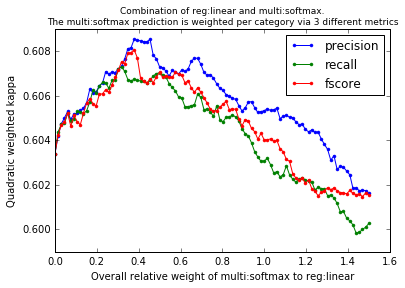

In [42]:
X, _ = np.meshgrid(np.arange(8), np.arange(len(clspred.yhtest)))

cls_dummies = pd.get_dummies(clspred.yhtest).values
cls_classes = X * cls_dummies

def classify(score):
    score = np.asarray(score)
    return np.rint(np.clip(score, -0.49, 7.49))

fig, ax = plt.subplots(1,1)

cls_factor = np.linspace(0., 1.5, 100)

for metric in ['precision', 'recall', 'fscore']:
    qwk = np.empty_like(cls_factor)
    for ii, f in enumerate(cls_factor):
        summed = np.dot(cls_classes, f * clsmetrics[metric].values.reshape(8,1))
        summed = np.squeeze(summed) + regpred.ystest

        norm = np.dot(cls_dummies, f * clsmetrics[metric].values.reshape(8,1)) 
        norm = np.squeeze(norm) + 1. 

        yhcomb = summed / norm
        yhcomb = classify(yhcomb)
        qwk[ii] = quadratic_weighted_kappa(regpred.ytest, yhcomb)


    ax.plot(cls_factor, qwk, '.-', label=metric)
    
ax.legend(loc='best')   
ax.set_title("Combination of reg:linear and multi:softmax.\n"
             "The multi:softmax prediction is weighted per category via 3 different metrics",
            fontsize=9)
ax.set_xlabel("Overall relative weight of multi:softmax to reg:linear")
ax.set_ylabel("Quadratic weighted kappa")

In the above result, note that when the overall relative weight is zero we simply recover the reg:linear results.  When the overall relative weight tends to infinity we recover the multi:softmax results.  

We clearly see that there is a benefit when we combine the classification results, and we obtain a slightly better prediction when we use the precision to weight the classification prediction differently for each category. 

For the overall weight, the best value is a relative weight of 0.4 to 1 (multi:softmax to reg:linear).  

## Conclusion of this step: 


* We found that a combination of reg:linear and multi:softmax can be better than either of them alone.  

* We found good parameters for either of this models via manual searching.  


## Next step:

* In the next step we will explore the classification function, which converts predicted scores into categories.  For now we have only been pinning to the nearest integer, but perhaps a lot can be gained if we do this in a smarter way. 